# Biaxial-strained antisites

In [10]:
from pymatgen.io.vasp.inputs import Structure
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])


from qubitPack.tool_box import get_db


In [6]:
def get_st(st, bottom=24, NN=None):
    data = []
    for st in [st]:
        if not NN:
            NN = e["NN"]
        print(np.round(np.array(st.lattice.abc)/5, 4).tolist())
        print(np.around(np.array([st.get_distance(NN[-1], x) for x in NN+[bottom] ]), 4))
        d = dict(
            zip(
                ["d1", "d2", "d3", "d4", "z1", "z2", "z3", "z4", "a", "b", "c"],
                np.around(
                    np.array(
                        [st.get_distance(NN[-1], x) for x in NN[:-1]+[bottom] ]+
                        [st.sites[NN[-1]].coords[-1] - st.sites[x].coords[-1] for x in NN[:-1]+[bottom]]+
                        np.round(np.array(st.lattice.abc)/5, 4).tolist()
                    ), 3
                )
            )
        )
        data.append(d)
    return data

In [7]:
db = get_db("single_photon_emitter", "standard_defect")
no_strain_ws0 = Structure.from_dict(db.collection.find_one({"task_id": 640})["output"]["structure"])

In [8]:
ws0_n25 = Structure.from_file("structure/ws0_-2.5.vasp")
ws0_p25 = Structure.from_file("structure/ws0_2.5.vasp")

FileNotFoundError: [Errno 2] No such file or directory: 'structure/ws0_-2.5.vasp'

In [ ]:
data = []
for strain, st in zip([-0.025, 0.025, 0], [ws0_n25, ws0_p25, no_strain_ws0]):
    geo = get_st(st, bottom=50, NN=[0, 6, 5, 25])
    geo[0].update({"strain": strain})
    data.extend(geo)
df = pd.DataFrame(data)
display(df.loc[:, ["strain", "d1", "z1", "z4", "a", "b"]])



In [ ]:
# db_name, col_name = "owls", "mx2_antisite_pc"
db_name, col_name = "single_photon_emitter", "standard_defect"

col = get_db(db_name, col_name).collection
# mx2s = col.find({"task_id":{"$in": [3091, 3083, 3093, 3097, 3094, 3102]}})
mx2s = col.find({"task_id": {"$in": [640, 642, 643, 632, 636, 653]}}) 
for e in mx2s:
    st = e["output"]["structure"]
    f = e["formula_pretty"]
    print(f)
    Structure.from_dict(st).to("poscar", "structure/antisite_{}.vasp".format(f))

## ZFS in antisite qubit paper

In [12]:
zfs0 = get_db("single_photon_emitter", "zfs")
Ds = []
es = zfs0.collection.find({"task_id": {"$in": [758, 759, 760, 761, 815]}})
for e in es:
    data = {}
    formula = "".join(e["formula"].split(" "))
    D = e["pyzfs_out"]["D"]/1000
    E = e["pyzfs_out"]["E"]/1000
    strain_ratio = 0
    taskid = e["task_id"]
    data.update({"taskid": taskid, "formula": formula, "D": D, "E":E, "strain_ratio": strain_ratio})
    Ds.append(data)
zfs0 = pd.DataFrame(Ds)
display(zfs0)

,taskid,formula,D,E,strain_ratio
0,758,W26Se49,6.807135,-0.000230,0
1,759,Mo26Se49,7.218477,-0.001220,0
2,760,W26S49,7.885142,-0.002513,0
3,761,Mo26S49,8.405764,-0.000181,0
4,815,W26S49,6.603212,-1.247016,0


## ZFS

In [13]:
biaxial_db = get_db("qubit_sensor", "monolayer_biaxial")
zfs_db = get_db("qubit_sensor", "zfs")
zfs0_D = zfs0.loc[zfs0["taskid"] == 760, "D"].iloc[0]

In [14]:
zfs_data = []
st_data = []
for e in zfs_db.collection.find():
    prev_fw_id = e["prev_fw_taskid"]
    prev_entry = biaxial_db.collection.find_one({"task_id": prev_fw_id})
    strain_ratio = prev_entry["perturbed"]["biaxial_ratio"]
    info = {
        "zfs_taskid": e["task_id"],
        "scf_taskid": e["prev_fw_taskid"],
        "formula": prev_entry["formula_pretty"],
        "strain_ratio": (strain_ratio - 1)*100, 
        "D": e["pyzfs_out"]["D"]*0.001,
        "E": e["pyzfs_out"]["E"]*0.001,
        "dD": e["pyzfs_out"]["D"]*0.001 - zfs0_D,
        "dD_in_percent": (e["pyzfs_out"]["D"]*0.001 - zfs0_D)/zfs0_D*100,
        "NN": prev_entry["NN"]
    }
    st = Structure.from_dict(prev_entry["output"]["structure"])
    if "Te" in info["formula"]:
        bottom = 50
    else:
        bottom = 24
    st_info = get_st(st, bottom=bottom, NN=info["NN"])
    st_info[0].update(
        {
            "zfs_taskid": e["task_id"],
            "scf_taskid": e["prev_fw_taskid"],
            "formula": prev_entry["formula_pretty"],
        }
    )
    zfs_data.append(info)
    st_data.extend(st_info)
    
zfs_df = pd.DataFrame(zfs_data)
display(zfs_df.round(2))

st_data = pd.DataFrame(st_data)
display(st_data.round(3).sort_values("formula"))

[3.2261, 3.2261, 4.6369]
[2.6316 2.6316 2.6316 0.     5.2346]
[3.0688, 3.0688, 4.6058]
[2.6332 2.6332 2.6332 0.     5.0263]
[3.3048, 3.3048, 4.6524]
[2.6276 2.6276 2.6276 0.     5.336 ]
[3.1117, 3.1117, 4.6291]
[2.6235 2.6235 2.6235 0.     5.0728]
[3.3294, 3.3294, 4.6798]
[2.5335 2.5335 2.5335 0.     4.1635]
[3.417, 3.417, 4.6977]
[2.5386 2.5386 2.5386 0.     4.2183]
[3.1936, 3.1936, 4.6456]
[2.6204 2.6204 2.6204 0.     5.1816]
[3.5922, 3.5922, 4.7334]
[2.5767 2.5766 2.5766 0.     4.2617]
[3.3573, 3.3573, 4.6787]
[2.5747 2.5747 2.5747 0.     5.366 ]
[3.4392, 3.4392, 4.6953]
[2.5746 2.5746 2.5746 0.     5.4596]
[3.6798, 3.6798, 4.7513]
[2.5185 2.5184 2.5184 0.     4.4386]
[3.0682, 3.0682, 4.6026]
[2.6598 2.6598 2.6598 0.     5.0327]
[3.1962, 3.1962, 4.6434]
[2.6518 2.6518 2.6518 0.     5.1949]
[3.1143, 3.1143, 4.6269]
[2.6477 2.6477 2.6477 0.     5.0891]
[2.9896, 2.9896, 4.5872]
[2.6531 2.6531 2.6531 0.     4.9279]
[3.2256, 3.2256, 4.6335]
[2.679  2.679  2.679  0.     5.2432]
[3.3043, 3

,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN
0,5,3,W26S49,2.5,7.24,-0.00,-0.65,-8.18,"[5, 6, 0, 25]"
1,6,4,W26S49,-2.5,8.17,-0.00,0.28,3.58,"[5, 6, 0, 25]"
2,8,7,W26S49,5.0,6.41,-0.00,-1.48,-18.77,"[5, 6, 0, 25]"
3,17,14,W26Se49,-5.0,6.33,-0.00,-1.56,-19.74,"[5, 6, 0, 25]"
4,18,13,Te49W26,-5.0,0.81,-0.22,-7.07,-89.68,"[54, 49, 55, 74]"
5,19,15,Te49W26,-2.5,-0.97,0.23,-8.86,-112.36,"[54, 49, 55, 74]"
6,20,16,W26Se49,-2.5,6.83,-0.00,-1.05,-13.35,"[5, 6, 0, 25]"
7,23,22,Te49W26,2.5,2.14,-0.60,-5.75,-72.88,"[54, 49, 55, 74]"
8,27,25,W26Se49,2.5,-1.40,0.46,-9.29,-117.77,"[5, 6, 0, 25]"
9,29,28,W26Se49,5.0,2.47,-0.36,-5.42,-68.68,"[5, 6, 0, 25]"


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,zfs_taskid,scf_taskid,formula
15,2.679,2.679,2.679,5.243,1.952,1.952,1.952,1.832,3.226,3.226,4.634,47,46,Mo26S49
14,2.653,2.653,2.653,4.928,2.041,2.041,2.041,1.896,2.990,2.990,4.587,44,41,Mo26S49
16,2.689,2.689,2.689,5.348,1.906,1.906,1.906,1.795,3.304,3.304,4.649,50,49,Mo26S49
11,2.660,2.660,2.660,5.033,2.014,2.014,2.014,1.878,3.068,3.068,4.603,38,37,Mo26S49
17,2.658,2.660,2.660,5.408,1.882,1.882,1.882,1.765,3.360,3.360,4.676,53,52,Mo26Se49
13,2.648,2.648,2.648,5.089,1.993,1.993,1.993,1.867,3.114,3.114,4.627,43,40,Mo26Se49
12,2.652,2.652,2.652,5.195,1.962,1.962,1.962,1.836,3.196,3.196,4.643,42,39,Mo26Se49
4,2.533,2.533,2.533,4.163,1.706,1.706,1.706,1.636,3.329,3.329,4.680,18,13,Te49W26
5,2.539,2.539,2.539,4.218,1.595,1.595,1.595,1.535,3.417,3.417,4.698,19,15,Te49W26
7,2.577,2.577,2.577,4.262,1.285,1.285,1.285,1.232,3.592,3.592,4.733,23,22,Te49W26


## ZFS plotting 

W26S49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
1,6.0,4.0,W26S49,-2.5,8.17,-0.0,0.28,3.58,"[5, 6, 0, 25]",NaN
2,NaN,NaN,W26S49,0.0,7.89,-0.0,NaN,NaN,NaN,760.0
0,5.0,3.0,W26S49,2.5,7.24,-0.0,-0.65,-8.18,"[5, 6, 0, 25]",NaN
2,8.0,7.0,W26S49,5.0,6.41,-0.0,-1.48,-18.77,"[5, 6, 0, 25]",NaN


W26Se49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
3,17.0,14.0,W26Se49,-5.0,6.33,-0.00,-1.56,-19.74,"[5, 6, 0, 25]",NaN
6,20.0,16.0,W26Se49,-2.5,6.83,-0.00,-1.05,-13.35,"[5, 6, 0, 25]",NaN
0,NaN,NaN,W26Se49,0.0,6.81,-0.00,NaN,NaN,NaN,758.0
8,27.0,25.0,W26Se49,2.5,-1.40,0.46,-9.29,-117.77,"[5, 6, 0, 25]",NaN
9,29.0,28.0,W26Se49,5.0,2.47,-0.36,-5.42,-68.68,"[5, 6, 0, 25]",NaN


Te49W26


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
4,18.0,13.0,Te49W26,-5.0,0.81,-0.22,-7.07,-89.68,"[54, 49, 55, 74]",NaN
5,19.0,15.0,Te49W26,-2.5,-0.97,0.23,-8.86,-112.36,"[54, 49, 55, 74]",NaN
7,23.0,22.0,Te49W26,2.5,2.14,-0.60,-5.75,-72.88,"[54, 49, 55, 74]",NaN
10,35.0,32.0,Te49W26,5.0,0.77,-0.00,-7.11,-90.23,"[54, 49, 55, 74]",NaN


Mo26S49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
14,44.0,41.0,Mo26S49,-5.0,7.99,-0.0,0.10,1.28,"[5, 6, 0, 25]",NaN
11,38.0,37.0,Mo26S49,-2.5,8.37,-0.0,0.49,6.20,"[5, 6, 0, 25]",NaN
3,NaN,NaN,Mo26S49,0.0,8.41,-0.0,NaN,NaN,NaN,761.0
15,47.0,46.0,Mo26S49,2.5,8.11,-0.0,0.23,2.88,"[5, 6, 0, 25]",NaN
16,50.0,49.0,Mo26S49,5.0,7.07,-0.0,-0.81,-10.30,"[5, 6, 0, 25]",NaN


Mo26Se49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
13,43.0,40.0,Mo26Se49,-5.0,6.62,-0.00,-1.27,-16.10,"[5, 6, 0, 25]",NaN
12,42.0,39.0,Mo26Se49,-2.5,7.26,-0.00,-0.62,-7.92,"[5, 6, 0, 25]",NaN
1,NaN,NaN,Mo26Se49,0.0,7.22,-0.00,NaN,NaN,NaN,759.0
17,53.0,52.0,Mo26Se49,2.5,6.99,-0.01,-0.90,-11.35,"[5, 6, 0, 25]",NaN


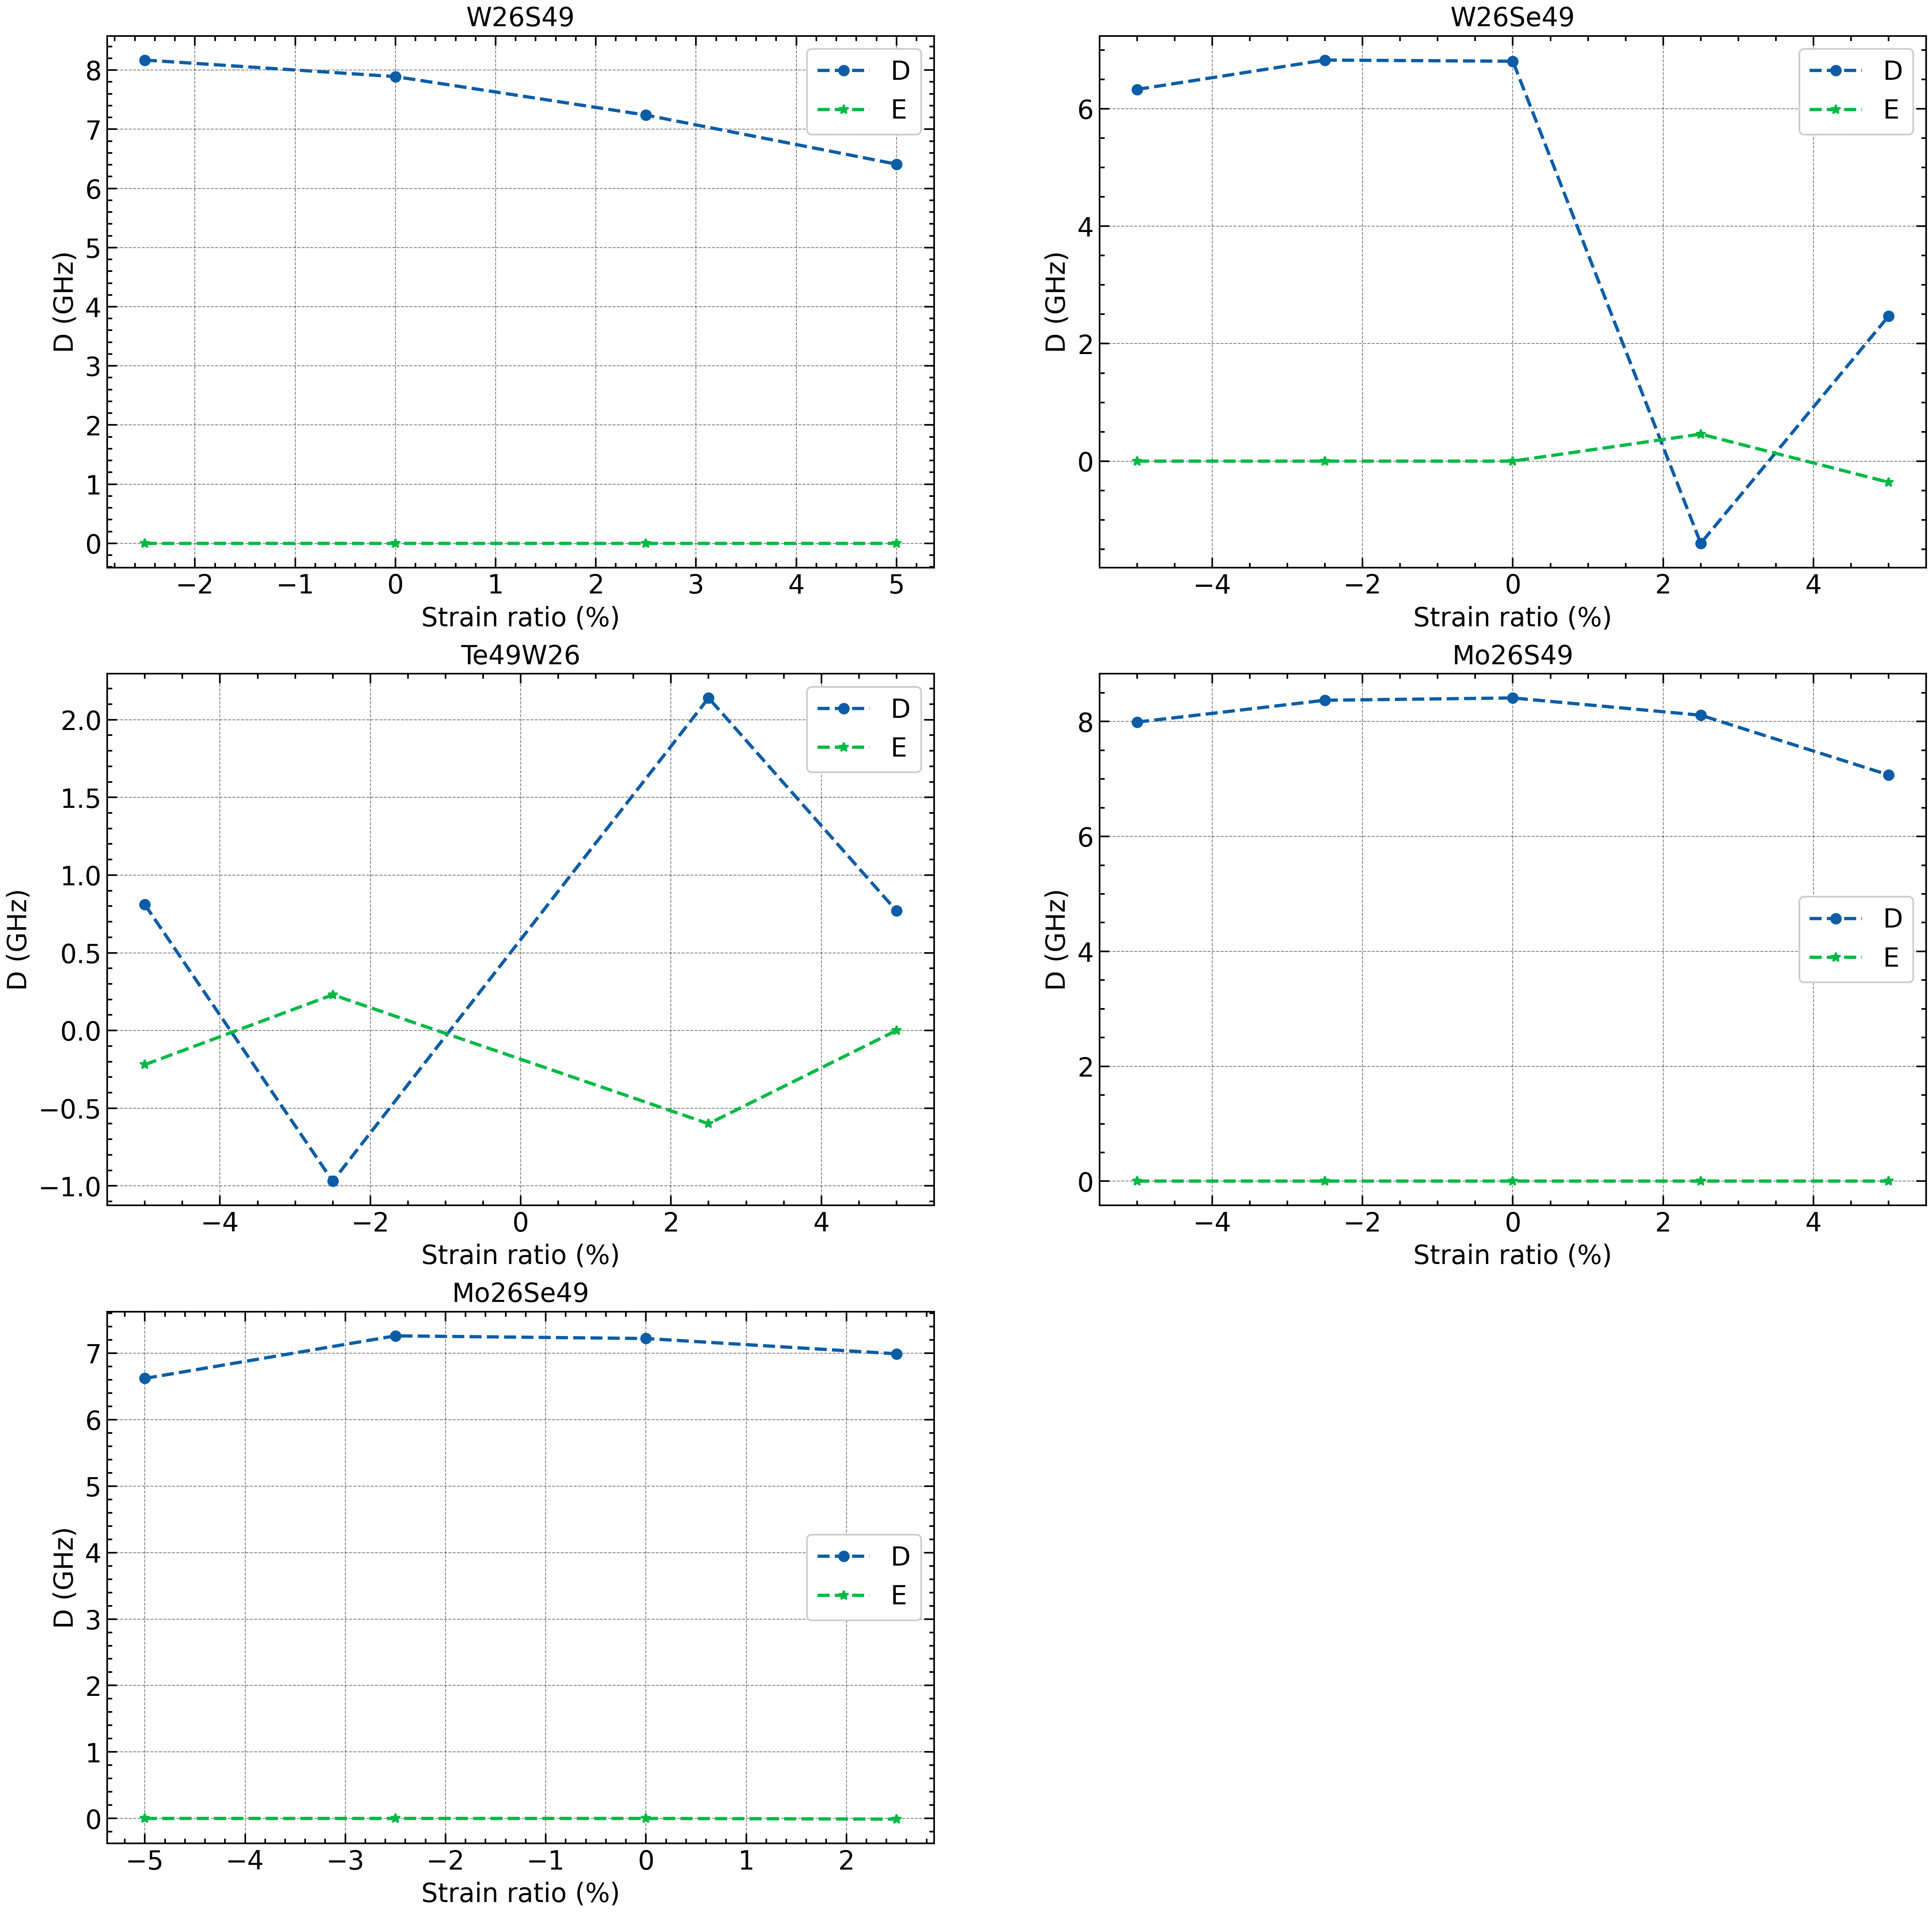

In [16]:
fig = plt.figure(dpi=300, figsize=(20, 20))
# fig.subplots_adjust(hspace=1, wspace=0.4)

for plt_idx, formula in enumerate(zfs_df["formula"].unique()):
    print(formula)
    zfs = zfs_df.loc[zfs_df["formula"] == formula, :]
    zfs0_condition = (zfs0["formula"].str.contains(formula)) & (zfs0["taskid"] != 815)
    zfs = zfs.append(zfs0.loc[zfs0_condition, :]).round(2).sort_values("strain_ratio")
    display(zfs)
    
    ax = fig.add_subplot(3, 2, plt_idx+1)
    ax.plot(zfs["strain_ratio"], zfs["D"], "o--", label="D")
    ax.plot(zfs["strain_ratio"], zfs["E"], "*--", label="E")

    ax.legend()
    ax.set_xlabel("Strain ratio (%)")
    ax.set_ylabel("D (GHz)")
    ax.set_title(formula)

display(fig)